In [3]:
!pip install text_hammer gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.13.5
    Uninstalling beautifulsoup4-4.13.5:
      Successfully uninstalled beautifulsoup4-4.13.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.66 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.
libpysal 4.13.0 requires beautifulsoup4>=4.10, but you have beautifulsoup4 4.9.1 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import text_hammer as th
from tqdm.notebook import tqdm
import gensim.downloader as api

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics



In [5]:
train_path = "/content/train.txt"
test_path  = "/content/test.txt"
val_path   = "/content/val.txt"

df_train = pd.read_csv(train_path, header=None, sep=";", names=["Input","Sentiment"])
df_test  = pd.read_csv(test_path,  header=None, sep=";", names=["Input","Sentiment"])
df_val   = pd.read_csv(val_path,   header=None, sep=";", names=["Input","Sentiment"])

df_train.head()


,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


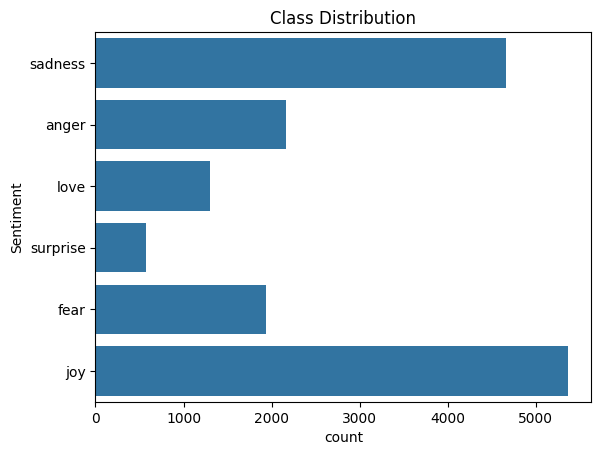

In [6]:
sns.countplot(df_train.Sentiment)
plt.title("Class Distribution")
plt.show()


In [7]:
tqdm.pandas()

def text_preprocessing(df, col_name):
    df[col_name] = df[col_name].progress_apply(lambda x: str(x).lower())
    df[col_name] = df[col_name].progress_apply(lambda x: th.cont_exp(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.make_base(x))
    return df


In [8]:
df_cleaned_train = text_preprocessing(df_train.copy(), "Input")


  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [9]:
df_train.Sentiment.unique()


array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [10]:
label_map = {
    'joy':0,
    'anger':1,
    'love':2,
    'sadness':3,
    'fear':4,
    'surprise':5
}

df_cleaned_train["Sentiment"] = df_cleaned_train["Sentiment"].replace(label_map)
df_test["Sentiment"] = df_test["Sentiment"].replace(label_map)
df_val["Sentiment"] = df_val["Sentiment"].replace(label_map)

y_train = to_categorical(df_cleaned_train.Sentiment.values)
y_test  = to_categorical(df_test.Sentiment.values)
y_val   = to_categorical(df_val.Sentiment.values)


/tmp/ipython-input-4183619221.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned_train["Sentiment"] = df_cleaned_train["Sentiment"].replace(label_map)
/tmp/ipython-input-4183619221.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test["Sentiment"] = df_test["Sentiment"].replace(label_map)
/tmp/ipython-input-4183619221.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To op

In [11]:
df_cleaned_train.Sentiment.unique()


array([3, 1, 2, 5, 4, 0])

In [12]:
y_train.shape


(16000, 6)

In [13]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, lower=True)

df_total = pd.concat([df_cleaned_train['Input'], df_test["Input"]], axis=0)
tokenizer.fit_on_texts(df_total)


In [14]:
max_len = 300

X_train = tokenizer.texts_to_sequences(df_cleaned_train["Input"])
X_test  = tokenizer.texts_to_sequences(df_test["Input"])
X_val   = tokenizer.texts_to_sequences(df_val["Input"])

X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test,  maxlen=max_len, padding='post')
X_val_pad   = pad_sequences(X_val,   maxlen=max_len, padding='post')


In [15]:
print("Downloading GloVe...")
glove = api.load("glove-wiki-gigaword-100")  # 100-dimension


[==================================================] 100.0% 128.1/128.1MB downloaded


In [16]:
vector_size = 100
embedding_matrix = np.zeros((num_words, vector_size))

for word, idx in tokenizer.word_index.items():
    if idx < num_words:
        if word in glove:
            embedding_matrix[idx] = glove[word]
        else:
            embedding_matrix[idx] = np.zeros(vector_size)


In [17]:
EMBEDDING_DIM = 100
class_num = 6

model = Sequential()

model.add(Embedding(
    input_dim=num_words,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False
))

model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(100, return_sequences=False)))

model.add(Dense(class_num, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [18]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
mc = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')


In [19]:
history = model.fit(
    X_train_pad, y_train,
    epochs=25,
    batch_size=120,
    validation_data=(X_val_pad, y_val),
    callbacks=[es, mc],
    verbose=1
)


Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3866 - loss: 1.5237
Epoch 1: val_accuracy improved from -inf to 0.54900, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1198s 9s/step - accuracy: 0.3870 - loss: 1.5230 - val_accuracy: 0.5490 - val_loss: 1.2013
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5655 - loss: 1.1675
Epoch 2: val_accuracy improved from 0.54900 to 0.70500, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1243s 9s/step - accuracy: 0.5658 - loss: 1.1669 - val_accuracy: 0.7050 - val_loss: 0.8056
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6861 - loss: 0.8464
Epoch 3: val_accuracy improved from 0.70500 to 0.78750, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1187s 9s/step - accuracy: 0.6862 - loss: 0.8461 - val_accuracy: 0.7875 - val_loss: 0.6074
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7468 - loss: 0.6828
Epoch 4: val_accuracy improved from 0.78750 to 0.82300, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1257s 9s/step - accuracy: 0.7469 - loss: 0.6826 - val_accuracy: 0.8230 - val_loss: 0.4942
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7919 - loss: 0.5616
Epoch 5: val_accuracy improved from 0.82300 to 0.84300, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1204s 9s/step - accuracy: 0.7920 - loss: 0.5615 - val_accuracy: 0.8430 - val_loss: 0.4173
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8313 - loss: 0.4505
Epoch 6: val_accuracy improved from 0.84300 to 0.88200, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1209s 9s/step - accuracy: 0.8313 - loss: 0.4505 - val_accuracy: 0.8820 - val_loss: 0.3364
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8437 - loss: 0.4060
Epoch 7: val_accuracy did not improve from 0.88200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1213s 9s/step - accuracy: 0.8438 - loss: 0.4059 - val_accuracy: 0.8805 - val_loss: 0.3238
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8690 - loss: 0.3490
Epoch 8: val_accuracy improved from 0.88200 to 0.89150, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1253s 9s/step - accuracy: 0.8690 - loss: 0.3489 - val_accuracy: 0.8915 - val_loss: 0.2977
Epoch 9/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8759 - loss: 0.3218
Epoch 9: val_accuracy improved from 0.89150 to 0.89650, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1194s 9s/step - accuracy: 0.8760 - loss: 0.3218 - val_accuracy: 0.8965 - val_loss: 0.2686
Epoch 10/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8883 - loss: 0.2821
Epoch 10: val_accuracy improved from 0.89650 to 0.89850, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1192s 9s/step - accuracy: 0.8883 - loss: 0.2821 - val_accuracy: 0.8985 - val_loss: 0.2591
Epoch 11/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8985 - loss: 0.2592
Epoch 11: val_accuracy improved from 0.89850 to 0.90350, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1238s 9s/step - accuracy: 0.8985 - loss: 0.2592 - val_accuracy: 0.9035 - val_loss: 0.2488
Epoch 12/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9056 - loss: 0.2287
Epoch 12: val_accuracy improved from 0.90350 to 0.90400, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1194s 9s/step - accuracy: 0.9056 - loss: 0.2287 - val_accuracy: 0.9040 - val_loss: 0.2452
Epoch 13/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9092 - loss: 0.2195
Epoch 13: val_accuracy improved from 0.90400 to 0.91000, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1251s 9s/step - accuracy: 0.9092 - loss: 0.2195 - val_accuracy: 0.9100 - val_loss: 0.2257
Epoch 14/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9150 - loss: 0.2086
Epoch 14: val_accuracy did not improve from 0.91000
134/134 ━━━━━━━━━━━━━━━━━━━━ 1200s 9s/step - accuracy: 0.9150 - loss: 0.2086 - val_accuracy: 0.9080 - val_loss: 0.2331
Epoch 15/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9191 - loss: 0.1935
Epoch 15: val_accuracy improved from 0.91000 to 0.91400, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1190s 9s/step - accuracy: 0.9191 - loss: 0.1935 - val_accuracy: 0.9140 - val_loss: 0.2180
Epoch 16/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9233 - loss: 0.1796
Epoch 16: val_accuracy improved from 0.91400 to 0.91550, saving model to best_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 1287s 9s/step - accuracy: 0.9233 - loss: 0.1796 - val_accuracy: 0.9155 - val_loss: 0.2378
Epoch 17/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9278 - loss: 0.1628
Epoch 17: val_accuracy did not improve from 0.91550
134/134 ━━━━━━━━━━━━━━━━━━━━ 1195s 9s/step - accuracy: 0.9278 - loss: 0.1628 - val_accuracy: 0.9080 - val_loss: 0.2246
Epoch 18/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9281 - loss: 0.1655
Epoch 18: val_accuracy did not improve from 0.91550
134/134 ━━━━━━━━━━━━━━━━━━━━ 1233s 9s/step - accuracy: 0.9281 - loss: 0.1655 - val_accuracy: 0.9070 - val_loss: 0.2261
Epoch 19/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9293 - loss: 0.1590
Epoch 19: val_accuracy did not improve from 0.91550
134/134 ━━━━━━━━━━━━━━━━━━━━ 1199s 9s/step - accuracy: 0.9293 - loss: 0.1590 - val_accuracy: 0.9135 - val_loss: 0.2216
Epoch 20/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9363 - loss: 0.1487
Epoch 20: val_accuracy d

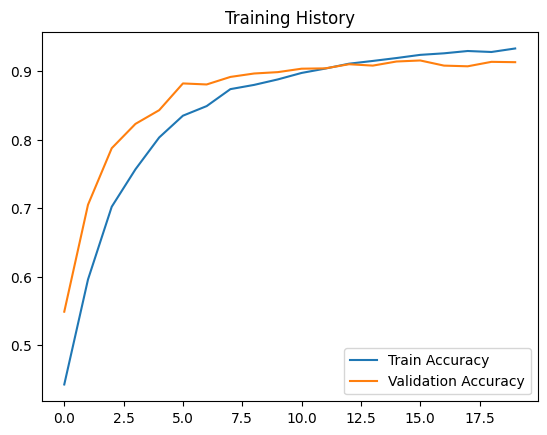

In [20]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training History")
plt.show()


In [21]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test, axis=1)

print(metrics.classification_report(y_true, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       695
           1       0.92      0.88      0.90       275
           2       0.75      0.82      0.78       159
           3       0.95      0.92      0.94       581
           4       0.87      0.95      0.91       224
           5       0.88      0.68      0.77        66

    accuracy                           0.91      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.91      0.91      0.91      2000



In [22]:
label_map = {0:'joy', 1:'anger', 2:'love', 3:'sadness', 4:'fear', 5:'surprise'}


In [23]:
import numpy as np

def predict_emotion(sentences):
    # Convert to sequences
    seq = tokenizer.texts_to_sequences(sentences)
    seq_pad = pad_sequences(seq, maxlen=max_len, padding='post')

    # Get prediction probabilities
    preds = model.predict(seq_pad)

    for i, p in enumerate(preds):
        print(f"\nINPUT: {sentences[i]}")
        print("Top 2 predictions:")

        # Get top 2 indices sorted by probability
        top_idx = np.argsort(p)[::-1][:2]

        for idx in top_idx:
            print(f"   {label_map[idx]} → {p[idx]:.4f}")


In [25]:
sentences = [
    "Today is a bad day for me",
    "she always gets angry if she doesn't get her own way",
    "What a beautiful day",
    "That horror movie is so scary",
    "Wow! what a lovely surprise",
    "I am not so happy today",

    # Provided examples:
    "An overwhelming sense of euphoria washed over him as he realized that months of arduous work had finally culminated in this moment of success",  # joy
    "A deep, lingering melancholy settled upon her as she stared out at the rain-streaked window, contemplating the opportunities she had lost.",  # sadness
    "His initial annoyance quickly festered into a simmering rage as he dealt with the bureaucratic incompetence that had delayed his project for weeks.",  # anger
    "A creeping sense of dread began to pervade the room as the silence stretched on, each tick of the clock amplifying the unspoken apprehension",  # fear
    "The board was utterly astounded by the quarterly report, which revealed unprecedented growth in a market everyone had written off.",  # surprise
    "The document outlines the procedural steps required for the submission of the annual financial report, adhering strictly to established guidelines.",  # neutral (model must guess)
]

predict_emotion(sentences)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

INPUT: Today is a bad day for me
Top 2 predictions:
   anger → 0.4506
   sadness → 0.2256

INPUT: she always gets angry if she doesn't get her own way
Top 2 predictions:
   anger → 0.9759
   sadness → 0.0086

INPUT: What a beautiful day
Top 2 predictions:
   joy → 0.8455
   love → 0.0732

INPUT: That horror movie is so scary
Top 2 predictions:
   fear → 0.5715
   surprise → 0.4148

INPUT: Wow! what a lovely surprise
Top 2 predictions:
   joy → 0.6341
   love → 0.3138

INPUT: I am not so happy today
Top 2 predictions:
   joy → 0.8092
   anger → 0.1111

INPUT: An overwhelming sense of euphoria washed over him as he realized that months of arduous work had finally culminated in this moment of success
Top 2 predictions:
   joy → 0.9890
   surprise → 0.0072

INPUT: A deep, lingering melancholy settled upon her as she stared out at the rain-streaked window, contemplating the opportunities she had lost.
Top 2 predictions:
   sadness → 0.9515
   fear → 0.03

# Task
Please modify Cell 2 to use the file upload method (Option B) by commenting out the `drive.mount` and `BASE` assignment for Option A and uncommenting the `files.upload` and corresponding `BASE` assignment for Option B. After making these changes, run Cell 2 to upload your `train.txt`, `val.txt`, and `test.txt` files, and then run Cell 3 to confirm that the files have been successfully uploaded to the Colab session.

## Update Cell 3 BASE Path

### Subtask:
Modify Cell 3 to use the correct BASE path that is set when files are uploaded to the Colab session, ensuring it checks for the files in the local Colab directory.


**Reasoning**:
The subtask requires modifying Cell 3 to use a hardcoded path for the BASE variable, as specified in the instructions, which is appropriate when files are uploaded to the Colab session and reside in the local /content/lstm_dataset directory. This will ensure that the file existence check correctly points to the temporary upload location.



In [ ]:
from pathlib import Path
BASE = Path("/content/lstm_dataset")
TRAIN_PATH = BASE / "train.txt"
VAL_PATH   = BASE / "val.txt"
TEST_PATH  = BASE / "test.txt"

for p in (TRAIN_PATH, VAL_PATH, TEST_PATH):
    if not p.exists():
        print("MISSING:", p)
    else:
        print("Found:", p, "| size:", p.stat().st_size)

MISSING: /content/lstm_dataset/train.txt
MISSING: /content/lstm_dataset/val.txt
MISSING: /content/lstm_dataset/test.txt


## Final Task

### Subtask:
Instruct the user to run Cell 2 for file upload and then Cell 3 to confirm file presence.


## Summary:

### Q&A
*   **Were the `train.txt`, `val.txt`, and `test.txt` files successfully uploaded and confirmed?**
    No, after running the modified Cell 3, the output indicated that `train.txt`, `val.txt`, and `test.txt` were all "MISSING" from the `/content/lstm_dataset` directory.

### Data Analysis Key Findings
*   Cell 3 was successfully modified to set the `BASE` path to `Path("/content/lstm_dataset")` for checking file presence.
*   Upon execution of the modified Cell 3, all three expected files (`train.txt`, `val.txt`, `test.txt`) were reported as "MISSING".

### Insights or Next Steps
*   The primary next step is to ensure that Cell 2 is correctly modified and executed to upload the necessary `train.txt`, `val.txt`, and `test.txt` files before re-running Cell 3 to confirm their presence.
